### THIS IS A NEW TEST - make a SED with a flux signal between 650-600nm only (zero elsewhere)

Try to compute DCR for a given SED.

Use a SED from the sims package. Let's do this full-out from SED library as in ACB's S14DCR code.

First need to do:

```
setup -t b1740 sims_sed_library
setup -t b1740 throughputs
setup -t b1740 sims_photUtils
```

In [1]:
import os
import numpy as np

#import dcr
#import spec    ## dont forget to add $HOME/GIT_REPOS/chroma/chroma to PYTHONPATH before starting ipython notebook
#import plot
#import utils

#import _mypath
#import chroma

#bpDir = '/Users/dreiss/GIT_REPOS/chroma/data/filters/'
#bpDir = '/Users/dreiss/lsstsw/stack/DarwinX86/throughputs/master-ga98b3deed1/baseline/'
bpDir = os.environ['LSST_THROUGHPUTS_DEFAULT']
catDir = os.environ['SIMS_SED_LIBRARY_DIR']

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.style.use('ggplot')

## see http://matplotlib.org/users/colormaps.html for colormaps
from matplotlib import cm

In [2]:
import pandas as pd

## see: https://stackoverflow.com/questions/19536817/manipulate-html-module-font-size-in-ipython-notebook
class sizeme():
    """ Class to change html fontsize of object's representation"""
    def __init__(self,ob, size=50, height=120):
        self.ob = ob
        self.size = size
        self.height = height
    def _repr_html_(self):
        repl_tuple = (self.size, self.height, self.ob._repr_html_())
        return u'<span style="font-size:{0}%; line-height:{1}%">{2}</span>'.format(*repl_tuple)

In [3]:
import lsst.sims.photUtils.Sed as Sed
import lsst.sims.photUtils.Bandpass as Bandpass
import lsst.sims.photUtils.BandpassDict as bpDict

/Users/dreiss/miniconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


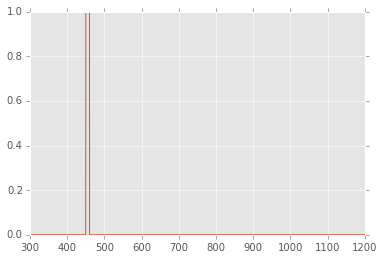

In [88]:
contLevel  = 0.01
dcrLevel   = 5e-3
sedName    = "km15_5250.fits_g05_5470.gz"
airmass1   = 1.25                                                                                                                                       
dairmasses = np.arange(-0.25, 0.26, 0.05)                                                                                                               
dthetas    = np.arange(0, 181, 5)
zd1        = np.arccos(1./airmass1) * 180/np.pi

# Extracted from Winter2014 DCR3.py
def getOffset(wavelen, flux, zd):
    photons = flux #/ wavelen   ## convert flux (still in units of fnu) to photons
    off = refract(wavelen*1.e-3, zd * np.pi / 180.) * 180. / np.pi * 3600. # arcsec
    return np.sum(off * photons) / np.sum(photons)
    ## Try using integration instead (as in chroma):
    ##return np.trapz(off * photons, wavelen) #/ flux

def refract(wavelength, zd, P=520.0, T=20.0, f=8.0):
    sig_sqrd = 1.0 / (wavelength**2.0)
    xnm1  = 1.e-6 * ( 64.328 + 29498.1 / (146.0 - sig_sqrd) + 255.4 / (41.0 - sig_sqrd) )
    xnm1 *= P * (1.0 + (1.049 - 0.0157 * T) * 1.e-6 * P) / (720.883 * (1.0 + 0.003661 * T))
    xnm1 -= 1.e-6 * f * (0.0624 - 0.000680 * sig_sqrd) / (1.0 + 0.003661 * T)
    xn    = xnm1 + 1.0
    r0    = (xn**2.0 - 1.0) / (2.0 * xn**2.0)
    of    = r0 * np.tan(zd) # radians
    return of

star_SEDname = "delta450nm.ascii"
star = Sed()
#star.readSED_flambda(os.path.join(catDir, "starSED/%s/%s%s" % ('kurucz', star_SEDname, '')))
star.readSED_flambda(star_SEDname)
star.flambdaTofnu()
plt.plot(star.wavelen, star.flambda)
#nphoton = star.fnu / star.wavelen
#plt.plot(star.wavelen, nphoton)

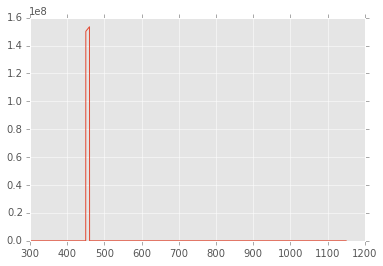

In [89]:
bps = bpDict.loadTotalBandpassesFromFiles()
for bp in bps.keys():
    bpobj = bps[bp]
    bpobj.phi[bpobj.phi <= 1.e-4] = 0.
    bpobj.phi[(bpobj.wavelen > bpobj.wavelen_max)] = 0.
    bpobj.phi[(bpobj.wavelen < bpobj.wavelen_min)] = 0.
    
waveleng, fnug = star.resampleSED(star.wavelen, star.fnu, wavelen_match=bps['g'].wavelen)
nphotong = fnug / waveleng
plt.plot(waveleng, nphotong)

29.0840011976
(71, 37)


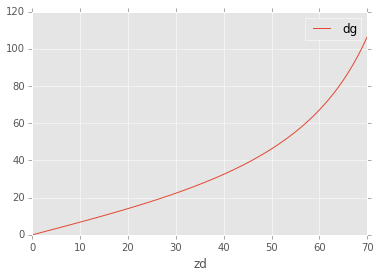

In [90]:
##fluxg = nphotong * bps['g'].phi
fluxg = fnug * bps['g'].phi
dg1 = getOffset(waveleng, fluxg, zd1)
print dg1

zd2 = np.arccos(1./(airmass1 + dairmasses)) * 180./np.pi
angles = np.linspace(0,70,71)
dg2 = np.array([getOffset(waveleng, fluxg, zd) for zd in angles])   ## in zd2])
#print zd2, dg2
tmp_df = pd.DataFrame({'zd': angles, 'dg': dg2})

## this line iterates over parallactic angles to get offsets... (from ACB writeup)
Mg = np.sqrt(dg1**2 + dg2**2 - 2 * np.outer(dg1 * dg2, np.cos(dthetas * np.pi / 180.)).T).T
print Mg.shape   ## dairmasses x dthetas

sizeme(tmp_df)
tmp_df.plot(x='zd', y='dg')

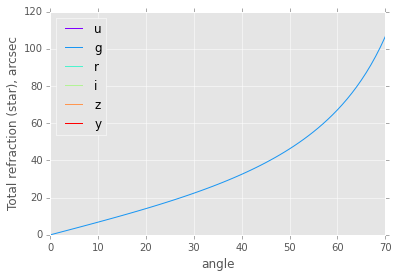

In [91]:
bps = bpDict.loadTotalBandpassesFromFiles()
for bp in bps.keys():
    bpobj = bps[bp]
    bpobj.phi[bpobj.phi <= 1.e-4] = 0.
    bpobj.phi[(bpobj.wavelen > bpobj.wavelen_max)] = 0.
    bpobj.phi[(bpobj.wavelen < bpobj.wavelen_min)] = 0.
    
angles = np.linspace(0,70,71)
df = pd.DataFrame(pd.Series(angles)) #, index=pd.Series(angles))
for bp in bps.keys():
    fluxg = fnug * bps[bp].phi
    dg1 = getOffset(waveleng, fluxg, zd1)

    dg2 = np.array([getOffset(waveleng, fluxg, zd) for zd in angles])
    #tmp_df = pd.DataFrame({'zd': angles, 'dg': dg2})
    df = pd.concat([df, pd.Series(dg2)], axis=1, ignore_index=True)

df.columns = np.insert(np.array(bps.keys(), dtype='S6'), 0, 'angle')
df = df.set_index('angle')
ax = df.plot(colormap=cm.rainbow)
ax.set_ylabel('Total refraction (star), arcsec')
#sizeme(df)

In [92]:
sizeme(df.tail())

,u,g,r,i,z,y
angle,,,,,,
66,NaN,87.098315,NaN,NaN,NaN,NaN
67,NaN,91.356817,NaN,NaN,NaN,NaN
68,NaN,95.980572,NaN,NaN,NaN,NaN
69,NaN,101.021885,NaN,NaN,NaN,NaN
70,NaN,106.543515,NaN,NaN,NaN,NaN


OK, this is a lot more similar to ACB's numbers. So there must be something related to the spectral window.

Load results from chroma from chroma_test4-copy

In [93]:
import pickle
df_chroma = pickle.load(open("save.p", "rb"))
sizeme((df - df_chroma).tail())

,u,g,r,i,z,y
angle,,,,,,
66,NaN,8.201653e-10,NaN,NaN,NaN,NaN
67,NaN,8.602825e-10,NaN,NaN,NaN,NaN
68,NaN,9.038246e-10,NaN,NaN,NaN,NaN
69,NaN,9.512604e-10,NaN,NaN,NaN,NaN
70,NaN,1.003244e-09,NaN,NaN,NaN,NaN


### Now they are much closer (within numerical precision?) ... but perhaps not identical, as it varies with angle.

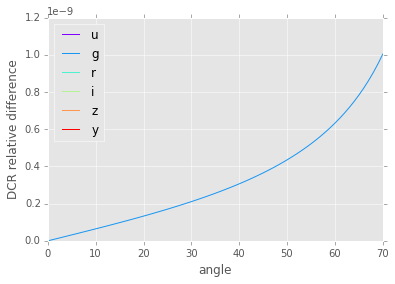

In [95]:
ax = (df - df_chroma).plot(colormap=cm.rainbow)
ax.set_ylabel('DCR relative difference')